In [ ]:
import tensorflow as teras

import pandas as pandinha

from numpy import array as array_numerico
from numpy import arange as gerar_numeros

from seaborn import lineplot

In [ ]:
nome_das_colunas = ['LV-ActivePower-kW', 'Wind-Speed-m/s', 'Theoretical-Power-Curve-KWh', 'Wind-Direction', 'potenciado']

funcionamento = ['Fora do Limite Aceitável', 'Dentro do Limite Aceitável']

resultados = {}

indice = gerar_numeros(0, 20)

In [ ]:
arquivo = pandinha.read_csv(teras.keras.utils.get_file(
    'raw_turbina_scala.csv',
    'https://raw.githubusercontent.com/vhsmdev/analytics-turbina-eolica/main/data/raw/raw_turbina_scala.csv'))

potenciado = []

for p, potencia in enumerate(list(arquivo['LV ActivePower (kW)'])):
  if potencia >= (arquivo.loc[p, 'Theoretical_Power_Curve (KWh)'] * 0.95) and potencia <= (arquivo.loc[p, 'Theoretical_Power_Curve (KWh)'] * 1.05):
    potenciado.append(1)

  else:
    potenciado.append(0)

arquivo['potenciado'] = potenciado

arquivo = pandinha.concat([arquivo, arquivo.loc[(arquivo['LV ActivePower (kW)'] == 0.0) |
                                                  (arquivo['Wind Speed (m/s)'] == 0.0) |
                                                  (arquivo['Theoretical_Power_Curve (KWh)'] == 0.0) |
                                                  (arquivo['Wind Direction (°)'] == 0.0)]])

arquivo = arquivo.drop_duplicates(keep = False).drop('Date/Time', axis = 1)

arquivo.columns = nome_das_colunas

treino = arquivo[9821:]

prova = arquivo[:9821]

for embaralhamento in range(1000):
  treino = treino.sample(frac = 1).reset_index(drop = True)

  prova = prova.sample(frac = 1).reset_index(drop = True)

treino_y = treino.pop('potenciado')

prova_y = prova.pop('potenciado')

In [ ]:
classificador = teras.keras.Sequential([teras.keras.Input(shape = (4, )),
                                        teras.keras.layers.Dense(24, activation='relu'),
                                        teras.keras.layers.Dense(12, activation='relu'),
                                        teras.keras.layers.Dense(2, activation='softmax')])

classificador.compile(optimizer = 'adam',
                      loss = 'sparse_categorical_crossentropy',
                      metrics = ['accuracy'])

treinamento = classificador.fit(treino, treino_y,
                                epochs = 20,
                                validation_data = (prova, prova_y))

resultados = treinamento.history

print(f'Precisão do Modelo: {resultados["val_accuracy"][19] * 100 :.2f}%')

Epoch 1/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8790 - loss: 3.3569 - val_accuracy: 0.8388 - val_loss: 0.8447
Epoch 2/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9316 - loss: 0.2893 - val_accuracy: 0.9260 - val_loss: 0.2755
Epoch 3/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9569 - loss: 0.1888 - val_accuracy: 0.9348 - val_loss: 0.4737
Epoch 4/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9621 - loss: 0.1891 - val_accuracy: 0.9288 - val_loss: 1.7187
Epoch 5/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9658 - loss: 0.1773 - val_accuracy: 0.9826 - val_loss: 0.0464
Epoch 6/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9714 - loss: 0.1435 - val_accuracy: 0.9294 - val_loss: 0.4017
Epoch 7/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9746 - loss: 0.1265 - val_accuracy: 0.9656 - val_loss: 0.1293
Epoch 8/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9751 - loss: 0.1600 - val_accuracy: 0.

In [ ]:
def graficado(dados, pre_dados = resultados, teste = bool):
  if not teste:
    prefixo = 'val_'

  else:
    prefixo = ''

  for valor in range(20):
    dados['valor'].append(pre_dados[prefixo + 'accuracy'][valor])
    dados['evento'].append('Precisão')
    dados['etapa'].append(indice[valor])

    dados['valor'].append(pre_dados[prefixo + 'loss'][valor])
    dados['evento'].append('Perda')
    dados['etapa'].append(indice[valor])

  return pandinha.DataFrame(dados)

<Axes: xlabel='etapa', ylabel='valor'>

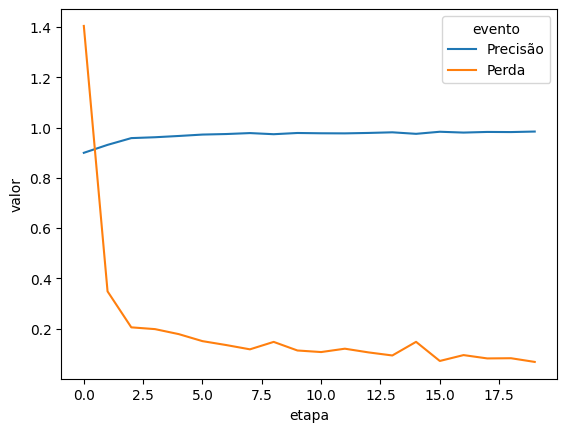

In [ ]:
pre_resultante = {'valor': [], 'evento': [], 'etapa': []}

lineplot(data = graficado(pre_resultante, teste = True), x = 'etapa', y = 'valor', hue = 'evento')

<Axes: xlabel='etapa', ylabel='valor'>

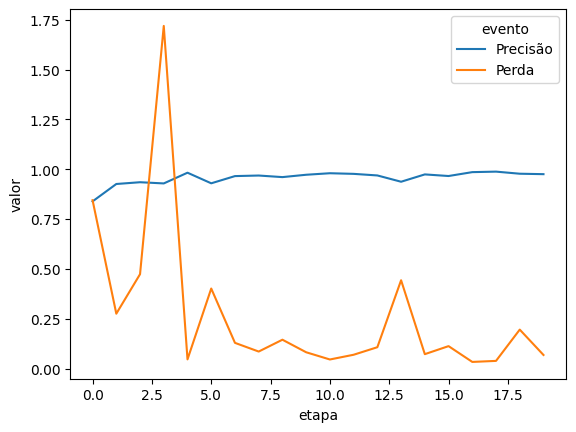

In [ ]:
resultante = {'valor': [], 'evento': [], 'etapa': []}

lineplot(data = graficado(resultante, teste = False), x = 'etapa', y = 'valor', hue = 'evento')

In [ ]:
def entrada(recursos):
  return teras.data.Dataset.from_tensor_slices(array_numerico(recursos)).batch(256)

In [ ]:
recursado = ['LV-ActivePower-kW', 'Wind-Speed-m/s', 'Theoretical-Power-Curve-KWh', 'Wind-Direction']
prever = []

380.7 5.4 458.2 11.7 esperado:0 resultado:0

2613.4 11.0 3284.7 72.2 esperado:0 resultado:0

1.0 3.7 84.7 78.5 esperado:0 resultado:0

491.4 5.7 542.1 69.1 esperado:0 resultado:0

2814.8 10.7 3195.4 213.9 esperado:0 resultado:0

3603.0 14.4 3600.0 198.7 esperado:1 resultado:1

835.8 6.8 941.6 190.3 esperado:0 resultado:0

440.8 5.5 471.3 37.9 esperado:0 resultado:0

2374.5 10.1 2884.0 201.7 esperado:0 resultado:0

893.0 9.0 2194.3 26.7 esperado:0 resultado:0

In [ ]:
for recurso in recursado:
  valido = True

  while valido:
    val = input(recurso + ': ')

    if not val.isdigit(): valido = False

  prever.append(float(val))

previsoes = classificador.predict(entrada([prever]))

prever = []

print(f'Previsto para {funcionamento[list(previsoes[0]).index(max(list(previsoes[0])))]}')

LV-ActivePower-kW: 3603.0
Wind-Speed-m/s: 14.4
Theoretical-Power-Curve-KWh: 3600.0
Wind-Direction: 198.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Previsto para Dentro do Limite Aceitável
